In [64]:
"""룰 기반 공행성 탐색 + LightGBM 회귀 예측 파이프라인 (v3).

1. train_month.csv를 월별 value 합계 pivot으로 변환
2. 피어슨 상관계수 규칙으로 (leader, follower) 공행성 쌍 탐색
3. follower/leader lag, diff, ratio 등 피처 생성 후 LightGBM 회귀 학습
4. 2025-08을 대상으로 pair별 value 예측
5. submission_{tag}_{오늘날짜}.csv 저장
"""
from __future__ import annotations
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

---------------------------------------------------------------------------
0. 데이터 적재 및 월별 pivot 생성
---------------------------------------------------------------------------

In [65]:
def load_monthly_data(path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """train_month.csv를 읽어 item_id × ym pivot 생성."""

    df = pd.read_csv(path)
    df["ym"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))

    monthly = (
        df.groupby(["item_id", "ym"], as_index=False)["value"]
        .sum()
        .rename(columns={"value": "value_sum"})
    )
    pivot = (
        monthly.pivot_table(index="ym", columns="item_id", values="value_sum", aggfunc="sum")
        .sort_index()
        .fillna(0.0)
    )
    return monthly, pivot

---------------------------------------------------------------------------
1. 공행성 쌍 탐색 (룰 기반)
---------------------------------------------------------------------------

In [66]:
def safe_corr(x: np.ndarray, y: np.ndarray) -> float:
    """분산=0 예외를 처리한 피어슨 상관계수."""

    if x.std() == 0 or y.std() == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

In [67]:
def find_comovement_pairs(
    pivot: pd.DataFrame,
    max_lag: int = 6,
    min_nonzero: int = 12,
    corr_threshold: float = 0.4,
) -> pd.DataFrame:
    """피어슨 룰 기반으로 (leader, follower) 공행성 쌍 탐색."""

    items = pivot.columns.tolist()
    pairs: List[Dict[str, float]] = []

    for leader in items:
        leader_series = pivot[leader].values.astype(float)
        if np.count_nonzero(leader_series) < min_nonzero:
            continue
        for follower in items:
            if leader == follower:
                continue
            follower_series = pivot[follower].values.astype(float)
            if np.count_nonzero(follower_series) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0
            for lag in range(1, max_lag + 1):
                if len(leader_series) <= lag:
                    break
                x = leader_series[:-lag]
                y = follower_series[lag:]
                corr = safe_corr(x, y)
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            if best_lag is None or abs(best_corr) < corr_threshold:
                continue

            pairs.append(
                {
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": int(best_lag),
                    "max_corr": float(best_corr),
                }
            )

    return pd.DataFrame(pairs)

---------------------------------------------------------------------------
2. 회귀용 학습 데이터 구성
---------------------------------------------------------------------------

In [68]:
def _build_pair_frame(
    pivot: pd.DataFrame,
    leader: str,
    follower: str,
    best_lag: int,
    max_corr: float,
) -> pd.DataFrame:
    """단일 pair에 대한 시점별 피처 계산."""

    leader_series = pivot[leader]
    follower_series = pivot[follower]

    df = pd.DataFrame({
        "date": pivot.index,
        "b_t": follower_series.values,
    })
    df["b_t_1"] = df["b_t"].shift(1)
    df["b_t_2"] = df["b_t"].shift(2)
    #df["b_t_3"] = df["b_t"].shift(3)
    #df["b_t_4"] = df["b_t"].shift(4)
    #df["b_t_5"] = df["b_t"].shift(5)
    df["b_diff1"] = df["b_t"] - df["b_t_1"]
    df["b_pct1"] = (df["b_t"] - df["b_t_1"]) / (df["b_t_1"].replace(0, np.nan) + 1e-6)
    df["b_roll3"] = follower_series.rolling(window=3, min_periods=3).mean().values
    #df["b_roll6"] = follower_series.rolling(window=6, min_periods=6).mean().values
    #df["b_roll12"] = follower_series.rolling(window=12, min_periods=12).mean().values

    # 타깃 등
    df["target_value"] = df["b_t"].shift(-1)
    df["target_log1p"] = np.log1p(df["target_value"].clip(lower=0))
    df["target_date"] = df["date"] + pd.offsets.MonthBegin(1)

    # 메타 정보
    df["leading_item_id"] = leader
    df["following_item_id"] = follower
    df["best_lag"] = best_lag
    df["max_corr"] = max_corr

    required_cols = [
        "b_t",
        "b_t_1",
        "b_t_2",
        "b_roll3",
        "b_diff1",
        "b_pct1",
        "a_t_lag",
        "a_t_lag_1",
        "a_diff_lag",
        "a_pct_lag",
        "target_value",
    ]
    
    # 필요한 경우 b_t_3~5, b_roll6/12도 추가!

    df = df.dropna(subset=[col for col in required_cols if col in df.columns])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

In [69]:
def build_training_data(pivot: pd.DataFrame, pairs: pd.DataFrame) -> pd.DataFrame:
    """모든 pair에 대한 학습용 레코드 결합."""

    frames = []
    for _, row in pairs.iterrows():
        pair_frame = _build_pair_frame(
            pivot,
            leader=row["leading_item_id"],
            follower=row["following_item_id"],
            best_lag=row["best_lag"],
            max_corr=row["max_corr"],
        )
        if not pair_frame.empty:
            frames.append(pair_frame)

    if not frames:
        raise ValueError("학습 데이터가 생성되지 않았습니다.")
    df = pd.concat(frames, ignore_index=True)
    df = df[df["target_date"].notna()]
    return df

---------------------------------------------------------------------------
3. LightGBM 회귀 모델 학습
---------------------------------------------------------------------------

In [ ]:
def lgbm_gridsearch(X_train, y_train, X_valid, y_valid, param_grid):
    best_results = []
    best_rmse = float("inf")
    best_params = None
    best_model = None
    search_points = [(lr, nl, md) for lr in param_grid["learning_rate"] 
                                  for nl in param_grid["num_leaves"] 
                                  for md in param_grid["max_depth"]]
    for lr, n_leaves, max_depth in tqdm(search_points, desc="LightGBM Search"):
        model = LGBMRegressor(
            objective="regression",
            n_estimators=1000,
            learning_rate=lr,
            num_leaves=n_leaves,
            max_depth=max_depth,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbosity=-1,
        )
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric="l2")
        y_pred = model.predict(X_valid)
        rmse = mean_squared_error(y_valid, y_pred) ** 0.5
        best_results.append({
            "learning_rate": lr,
            "num_leaves": n_leaves,
            "max_depth": max_depth,
            "rmse": rmse
        })
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {"learning_rate": lr, "num_leaves": n_leaves, "max_depth": max_depth}
            best_model = model
    return best_model, best_params, best_rmse

def xgb_gridsearch(X_train, y_train, X_valid, y_valid, param_grid):
    best_rmse = float("inf")
    best_params, best_model = None, None
    search_points = [(lr, md) for lr in param_grid["learning_rate"] 
                              for md in param_grid["max_depth"]]
    for lr, max_depth in tqdm(search_points, desc="XGBoost Search"):
        xgb_depth = 0 if max_depth == -1 else max_depth
        model = XGBRegressor(
            objective='reg:squarederror',
            n_estimators=1000,
            learning_rate=lr,
            max_depth=xgb_depth,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbosity=0
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        rmse = mean_squared_error(y_valid, y_pred) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {"learning_rate": lr, "max_depth": max_depth}
            best_model = model
    return best_model, best_params, best_rmse

def catboost_gridsearch(X_train, y_train, X_valid, y_valid, param_grid):
    best_rmse = float("inf")
    best_params, best_model = None, None
    search_points = [(lr, md) for lr in param_grid["learning_rate"] 
                              for md in param_grid["max_depth"]]
    for lr, max_depth in tqdm(search_points, desc="CatBoost Search"):
        if max_depth > 16:
            continue  # 건너뜀
        model = CatBoostRegressor(
            learning_rate=lr,
            iterations=1000,
            random_state=42,
            verbose=0
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        rmse = mean_squared_error(y_valid, y_pred) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {"learning_rate": lr, "depth": max_depth}
            best_model = model
    return best_model, best_params, best_rmse

def train_ensemble_models(X_train, y_train, X_valid, y_valid, param_grid):
    lgbm_model, lgbm_params, lgbm_rmse = lgbm_gridsearch(X_train, y_train, X_valid, y_valid, param_grid)
    xgb_model, xgb_params, xgb_rmse = xgb_gridsearch(X_train, y_train, X_valid, y_valid, param_grid)
    cat_model, cat_params, cat_rmse = catboost_gridsearch(X_train, y_train, X_valid, y_valid, param_grid)
    print(f"\nBest LGBM params: {lgbm_params} | RMSE {lgbm_rmse:.6f}")
    print(f"Best XGB params: {xgb_params} | RMSE {xgb_rmse:.6f}")
    print(f"Best CAT params: {cat_params} | RMSE {cat_rmse:.6f}")
    return [lgbm_model, xgb_model, cat_model]

def predict_ensemble(models, X):
    preds = [model.predict(X) for model in models]
    return np.mean(preds, axis=0)


In [71]:
def train_regression_model(train_df: pd.DataFrame):
    train_cutoff = pd.Timestamp("2024-12-01")
    valid_start = pd.Timestamp("2025-01-01")
    valid_end = pd.Timestamp("2025-05-01")

    drop_cols = {"date", "target_date", "target_value", "target_log1p", "leading_item_id", "following_item_id"}
    feature_cols = [col for col in train_df.columns if col not in drop_cols]

    train_mask = train_df["target_date"] <= train_cutoff
    valid_mask = (train_df["target_date"] >= valid_start) & (train_df["target_date"] <= valid_end)

    if train_mask.sum() == 0 or valid_mask.sum() == 0:
        raise ValueError("train/valid 기간 데이터가 부족합니다.")

    X_train = train_df.loc[train_mask, feature_cols]
    y_train = train_df.loc[train_mask, "target_log1p"]
    X_valid = train_df.loc[valid_mask, feature_cols]
    y_valid = train_df.loc[valid_mask, "target_log1p"]

    param_grid = {
        "learning_rate": [0.03, 0.05, 0.07, 0.1, 0.13, 0.15, 0.18, 0.2],
        "num_leaves": [31, 63, 95, 127, 160],
        "max_depth": [7, 12, 15, 20, -1]
    }

    # 앙상블 모델들 반환 (LightGBM, XGBoost, CatBoost)
    models = train_ensemble_models(X_train, y_train, X_valid, y_valid, param_grid)
    return models, feature_cols


In [72]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_cols, topn=20):
    imp = model.feature_importances_
    # 상위 N개만 보기
    sorted_idx = np.argsort(imp)[::-1][:topn]
    plt.figure(figsize=(8, 6))
    plt.barh(np.array(feature_cols)[sorted_idx], imp[sorted_idx])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    # 중요도 내림차순 순서의 feature 이름 리스트 반환(자동화 실험용)
    return list(np.array(feature_cols)[sorted_idx])




---------------------------------------------------------------------------
4. 예측 월 피처 생성
---------------------------------------------------------------------------

In [73]:
def build_inference_features(
    pivot: pd.DataFrame,
    pairs: pd.DataFrame,
    forecast_month: str,
) -> pd.DataFrame:
    """forecast_month(예: 2025-08)에 대한 pair별 입력 피처 생성."""

    target_ts = pd.Timestamp(forecast_month + "-01")
    base_ts = target_ts - pd.offsets.MonthBegin(1)
    if base_ts not in pivot.index:
        raise ValueError(f"{base_ts.date()} 기준 데이터가 없습니다.")

    rows = []
    for _, row in pairs.iterrows():
        pair_frame = _build_pair_frame(
            pivot,
            leader=row["leading_item_id"],
            follower=row["following_item_id"],
            best_lag=row["best_lag"],
            max_corr=row["max_corr"],
        )
        target_row = pair_frame[pair_frame["target_date"] == target_ts]
        if not target_row.empty:
            rows.append(target_row.iloc[0].copy())

    if not rows:
        return pd.DataFrame()
    return pd.DataFrame(rows)

---------------------------------------------------------------------------
5. 제출 파일 생성
---------------------------------------------------------------------------

In [74]:
def create_submission(
    pairs: pd.DataFrame,
    pred_df: pd.DataFrame,
    pivot: pd.DataFrame,
    models: list,
    feature_cols: list,
) -> pd.DataFrame:
    """pair 목록에 예측 value를 결합하여 submission 생성."""

    submission = pairs[["leading_item_id", "following_item_id"]].drop_duplicates().reset_index(drop=True)
    latest_map = pivot.iloc[-1].to_dict()

    if pred_df.empty:
        submission["value"] = submission["following_item_id"].map(latest_map).fillna(0.0)
    else:
        X_test = pred_df[feature_cols].fillna(0.0)
        y_pred = predict_ensemble(models, X_test)
        y_pred = np.maximum(0.0, np.expm1(y_pred))
        pred_values = pred_df[["leading_item_id", "following_item_id"]].copy()
        pred_values["value"] = y_pred

        submission = submission.merge(
            pred_values,
            on=["leading_item_id", "following_item_id"],
            how="left",
        )
        submission["value"] = submission["value"].fillna(
            submission["following_item_id"].map(latest_map)
        )

    submission["value"] = submission["value"].fillna(0.0)
    submission["value"] = submission["value"].clip(lower=0).round().astype(int)
    submission.drop_duplicates(["leading_item_id", "following_item_id"], inplace=True)
    submission.reset_index(drop=True, inplace=True)
    return submission

---------------------------------------------------------------------------
6. 메인 실행부 (sweep으로 교체)
---------------------------------------------------------------------------

In [75]:
def sweep_thresholds_and_select_topN(
    pivot, 
    thresholds = [0.25, 0.28, 0.32, 0.35, 0.40],
    topN=3,
    min_nonzero=8
):
    results = []
    for th in thresholds:
        try:
            pairs = find_comovement_pairs(
                pivot, max_lag=6, min_nonzero=min_nonzero, corr_threshold=th
            )
            print(f"Threshold={th}: pairs={len(pairs)}")
            if pairs.empty:
                print(f"Threshold={th}: No pairs found, skipped")
                continue
            train_df = build_training_data(pivot, pairs)
            print(f"Threshold={th}: train_df rows={len(train_df)}")
            models, feature_cols = train_regression_model(train_df)
            
            # Validation set 추출
            valid_start = pd.Timestamp("2025-01-01")
            valid_end = pd.Timestamp("2025-05-01")
            valid_mask = (
                (train_df["target_date"] >= valid_start) & (train_df["target_date"] <= valid_end)
            )
            X_valid = train_df.loc[valid_mask, feature_cols]
            y_valid = train_df.loc[valid_mask, "target_log1p"]

            # Validation Score (예: RMSE)
            from sklearn.metrics import mean_squared_error
            y_pred = predict_ensemble(models, X_valid)
            rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

            results.append({
                'threshold': th,
                'rmse': rmse,
                'pair_count': len(pairs),
                # 필요시 model, feature_cols 등 추가 저장
            })

            print(f"Threshold={th:.3f} | pairs={len(pairs)} | Validation RMSE={rmse:.6f}")

        except Exception as e:
            print(f"Threshold={th:.3f}: {e}")

    # Top-N 성적 좋은 후보만 정렬 출력
    results = sorted(results, key=lambda x: x['rmse'])
    print("\n--- Top N Validation Candidates ---")
    for i, r in enumerate(results[:topN]):
        print(f"Rank {i+1}: threshold={r['threshold']:.3f} | pairs={r['pair_count']} | RMSE={r['rmse']:.6f}")
    
    return results[:topN]


pivot columns: Index(['AANGBULD', 'AHMDUILJ', 'ANWUJOKX', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ',
       'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG',
       'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB',
       'DUCMGGNW', 'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN',
       'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'FWUCPMMW', 'GIKPEWTY', 'GKQIJYDH',
       'GMBFCMIU', 'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY',
       'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KFQSHBNH',
       'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML',
       'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV', 'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU',
       'OJIFIHMZ', 'OKMBFVKS', 'OXKURKXR', 'PLMZALFA', 'PYZMVUWD', 'QJQJSWFU',
       'QKXNTIIB', 'QRKRBYJL', 'QSDCUCLB', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM',
       'RJCAXSGH', 'RJGPVEXX', 'ROACSLMG', 'RUVXNNVA', 'SAAYMURU', 'SAHWCZNH',
       'SDWAYPIK', 'SNHYOVBM', 'STZDB

CatBoost Search: 100%|██████████| 40/40 [02:20<00:00,  3.51s/it]



Best LGBM params: {'learning_rate': 0.1, 'num_leaves': 63, 'max_depth': 15} | RMSE 2.182094
Best XGB params: {'learning_rate': 0.2, 'max_depth': 12} | RMSE 2.202241
Best CAT params: {'learning_rate': 0.03, 'depth': 7} | RMSE 2.151080
Threshold=0.250 | pairs=4864 | Validation RMSE=2.121849
Threshold=0.28: pairs=3941
Threshold=0.28: train_df rows=148850


CatBoost Search: 100%|██████████| 40/40 [02:03<00:00,  3.08s/it]



Best LGBM params: {'learning_rate': 0.03, 'num_leaves': 160, 'max_depth': 15} | RMSE 2.227961
Best XGB params: {'learning_rate': 0.07, 'max_depth': 15} | RMSE 2.217852
Best CAT params: {'learning_rate': 0.03, 'depth': 7} | RMSE 2.194191
Threshold=0.280 | pairs=3941 | Validation RMSE=2.152977
Threshold=0.32: pairs=2927
Threshold=0.32: train_df rows=110550


CatBoost Search: 100%|██████████| 40/40 [01:42<00:00,  2.57s/it]



Best LGBM params: {'learning_rate': 0.1, 'num_leaves': 63, 'max_depth': 7} | RMSE 2.114490
Best XGB params: {'learning_rate': 0.18, 'max_depth': 15} | RMSE 2.098684
Best CAT params: {'learning_rate': 0.03, 'depth': 7} | RMSE 2.151633
Threshold=0.320 | pairs=2927 | Validation RMSE=2.055713
Threshold=0.35: pairs=2289
Threshold=0.35: train_df rows=86258


CatBoost Search: 100%|██████████| 40/40 [01:25<00:00,  2.14s/it]



Best LGBM params: {'learning_rate': 0.13, 'num_leaves': 63, 'max_depth': 7} | RMSE 2.198920
Best XGB params: {'learning_rate': 0.13, 'max_depth': -1} | RMSE 2.143138
Best CAT params: {'learning_rate': 0.03, 'depth': 7} | RMSE 2.198305
Threshold=0.350 | pairs=2289 | Validation RMSE=2.111629
Threshold=0.38: pairs=1796
Threshold=0.38: train_df rows=67559


CatBoost Search: 100%|██████████| 40/40 [01:15<00:00,  1.89s/it]



Best LGBM params: {'learning_rate': 0.18, 'num_leaves': 63, 'max_depth': 7} | RMSE 2.213016
Best XGB params: {'learning_rate': 0.13, 'max_depth': 7} | RMSE 2.156137
Best CAT params: {'learning_rate': 0.03, 'depth': 7} | RMSE 2.214938
Threshold=0.380 | pairs=1796 | Validation RMSE=2.133550
Threshold=0.4: pairs=1513
Threshold=0.4: train_df rows=56725


CatBoost Search: 100%|██████████| 40/40 [01:09<00:00,  1.75s/it]



Best LGBM params: {'learning_rate': 0.05, 'num_leaves': 160, 'max_depth': 15} | RMSE 2.261884
Best XGB params: {'learning_rate': 0.1, 'max_depth': 7} | RMSE 2.323827
Best CAT params: {'learning_rate': 0.03, 'depth': 7} | RMSE 2.184632
Threshold=0.400 | pairs=1513 | Validation RMSE=2.216027

--- Top N Validation Candidates ---
Rank 1: threshold=0.320 | pairs=2927 | RMSE=2.055713
Rank 2: threshold=0.350 | pairs=2289 | RMSE=2.111629
Rank 3: threshold=0.250 | pairs=4864 | RMSE=2.121849


CatBoost Search: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


Best LGBM params: {'learning_rate': 0.1, 'num_leaves': 63, 'max_depth': 7} | RMSE 2.114490
Best XGB params: {'learning_rate': 0.18, 'max_depth': 15} | RMSE 2.098684
Best CAT params: {'learning_rate': 0.03, 'depth': 7} | RMSE 2.151633


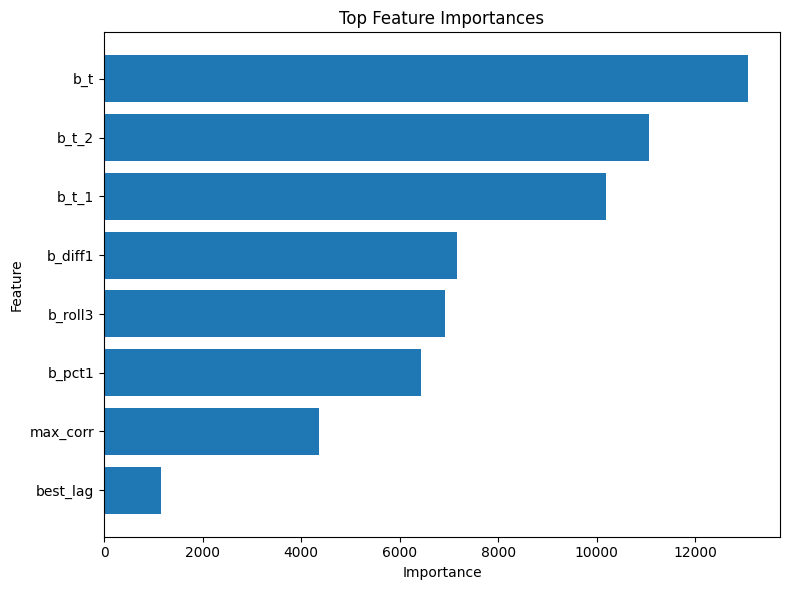

submission_rulelgbm_v3_th32_20251123.csv 저장 완료 (총 2927개 pair)


In [ ]:
def main():
    data_path = "train_month.csv"
    forecast_month = "2025-08"
    thresholds = [0.25, 0.28, 0.32, 0.35, 0.38, 0.40]  # 0.4~0.5 구간으로 올려서 실험!
    topN = 3
    min_nonzero = 8     

    # pivot 먼저 정의!
    _, pivot = load_monthly_data(data_path)
    print("pivot columns:", pivot.columns)
    print("pivot shape:", pivot.shape)
    print("nonzero counts:", [np.count_nonzero(pivot[col]) for col in pivot.columns])

    # 그 다음 sweep 함수 실행!
    top_candidates = sweep_thresholds_and_select_topN(pivot, thresholds, topN, min_nonzero=min_nonzero)
    if not top_candidates:
        raise ValueError("Sweep 후보가 없습니다. threshold 범위, 데이터 조건, 쌍 생성 결과를 점검하세요.")
    best = top_candidates[0]

    pairs = find_comovement_pairs(
        pivot, max_lag=6, min_nonzero=min_nonzero, corr_threshold=best["threshold"]
    )
    train_df = build_training_data(pivot, pairs)
    models, feature_cols = train_regression_model(train_df)
    plot_feature_importance(models[0], feature_cols, topn=20)

    pred_df = build_inference_features(pivot, pairs, forecast_month)
    submission = create_submission(pairs, pred_df, pivot, models, feature_cols)
    today = pd.Timestamp.today().strftime("%Y%m%d")
    output_path = f"submission_ensemble_v4_th{int(best['threshold']*100)}_{today}.csv"
    submission.to_csv(output_path, index=False)
    print(f"{output_path} 저장 완료 (총 {len(submission)}개 pair)")

if __name__ == "__main__":
    main()
